In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.linear_model import Lasso as Lasso_Reg
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize']=12,10

In [2]:
data = pd.read_csv('data_normalized.csv')
data.head(5)

,weight,height,closing,open_00_02,open_02_04,open_04_06,open_06_08,open_08_10,open_10_12,open_12_14,...,cuisine_y_Regional,cuisine_y_Seafood,cuisine_y_Vietnamese,parking_lot_none,parking_lot_public,parking_lot_valet parking,parking_lot_yes,smoking,age,target
0,0.258262,0.569555,-2.839010,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,-0.451192,2
1,0.258262,0.569555,0.814568,1,1,1,1,1,1,1,...,0,0,0,0,1,0,0,0,-0.451192,0
2,0.258262,0.569555,-0.403292,0,0,0,0,0,1,1,...,0,1,0,0,0,0,1,0,-0.451192,1
3,0.258262,0.569555,0.510103,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,-0.451192,2
4,0.258262,0.569555,0.510103,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,-0.451192,2


## training set, validation set, testing set

In [3]:
def split_data(data_x: np.ndarray, data_y: np.ndarray):
    
    ordering = np.arange(data_x.shape[0])
    np.random.shuffle(ordering)
    data_x = data_x[ordering]
    data_y = data_y[ordering]
    
    valid_start = int(len(data_x) * 0.7)
    test_start = int(len(data_x) * 0.9)
    
    train_set = (data_x[:valid_start], data_y[:valid_start])
    valid_set = (data_x[valid_start:test_start], data_y[valid_start:test_start])
    test_set = (data_x[test_start:], data_y[test_start:])
    
    return train_set, valid_set, test_set

In [4]:
y = np.array(data['target'])
x = np.array(data.drop(['target'], axis=1))

train_set, valid_set, test_set = split_data(x,y)

print(train_set[0].shape)
print(valid_set[0].shape)
print(test_set[0].shape)

(2055, 136)
(587, 136)
(294, 136)


In [5]:
x_train = train_set[0]
y_train = train_set[1]

x_val = valid_set[0]
y_val = valid_set[1]

x_test = test_set[0]
y_test = test_set[1]

# Logistic regression

In [6]:
n=30

C_arr = np.linspace(-10, 5, n)
train_accuracy = np.zeros(n)
val_accuracy = np.zeros(n)

for ind, C in enumerate(C_arr):    
    
    logreg = LogisticRegression(solver='newton-cg', C=10**C)
    logreg.fit(x_train, y_train)

    
    # Evaluate train & test performance
    output = logreg.predict(x_train)
    target = y_train
    train_accuracy[ind] =sum(output == target)/ len(target)

    output = logreg.predict(x_val)
    target = y_val
    val_accuracy[ind] =sum(output == target)/ len(target)

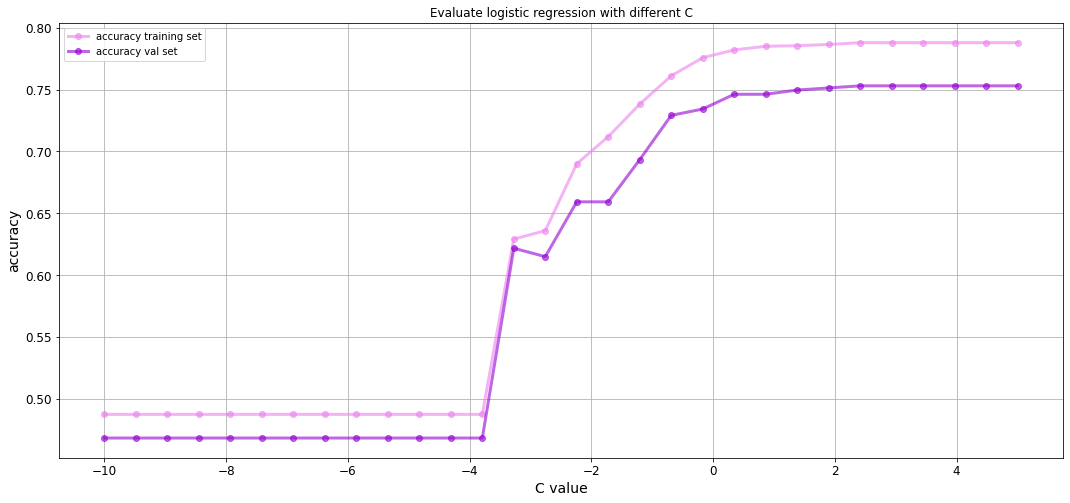

In [7]:
# Plotting
plt.figure(figsize=(18, 8))

plt.plot(C_arr, train_accuracy, 'bo-', label=r'accuracy training set', color="violet", alpha=0.6, linewidth=3)
plt.plot(C_arr, val_accuracy, 'bo-', label=r'accuracy val set', color="darkviolet", alpha=0.6, linewidth=3)

plt.xlabel('C value'); plt.ylabel(r'accuracy')
plt.title(r'Evaluate logistic regression with different C')
plt.legend(loc='best')
plt.grid()

# FINAL EVALUATION OF THE MODEL

In [8]:
index = np.argmax(val_accuracy)
C_best= C_arr[index]

logreg = LogisticRegression(solver = 'newton-cg',C=10)
logreg.fit(x_train, y_train)
coefficients = logreg.coef_

print('Logistic Regression')

output = logreg.predict(x_train)
target = y_train
accuracy = sum(output == target)/ len(target)
print("\nAccuracy on train set: {:.2f} %".format(accuracy*100))

output = logreg.predict(x_val)
target = y_val
accuracy = sum(output == target)/ len(target)
print("\nAccuracy on validation set: {:.2f} %".format(accuracy*100))


output = logreg.predict(x_test)
target = y_test
accuracy = sum(output == target)/ len(target)
print("\nAccuracy on testing set: {:.2f} %".format(accuracy*100))

Logistic Regression

Accuracy on train set: 78.59 %

Accuracy on validation set: 74.45 %

Accuracy on testing set: 74.15 %


### Check, what features have highest and lowest coefficients in logistic regression

In [9]:
features = list(data.columns)[:-1]

def get_most_correlated(coeffs, features, treshold):
    coeffs, features = zip(*sorted(zip( coeffs, features)))  

    for coef, feat in zip(coeffs, features):
        if abs(coef) > treshold:
            print("coef = {:.4f} \tfor\t {:}".format(coef, feat))
            
            
def get_least_correlated(coeffs, features, treshold):
    coeffs, features = zip(*sorted(zip( coeffs, features)))  ## sorting elements in (val, freq) indexing on 

    for coef, feat in zip(coeffs, features):
        if abs(coef) < treshold:
            print("coef = {:.4f} \tfor\t {:}".format(coef, feat))

## most important

In [10]:
print("Most correlated for 0 star")
get_most_correlated(coefficients[0], features, 2)

Most correlated for 0 star
coef = -2.6159 	for	 activity_professional
coef = -2.5634 	for	 religion_Mormon
coef = -2.4370 	for	 cuisine_x_Japanese
coef = 2.4382 	for	 religion_Jewish
coef = 2.6787 	for	 marital_status_widow
coef = 2.7283 	for	 cuisine_x_Turkish
coef = 3.5248 	for	 activity_unemployed


In [11]:
print("Most correlated for 1 star")
get_most_correlated(coefficients[1], features, 2)

Most correlated for 1 star
coef = -2.2664 	for	 marital_status_widow
coef = -2.1109 	for	 cuisine_y_Vietnamese
coef = 2.1773 	for	 cuisine_y_Game
coef = 2.2106 	for	 religion_Mormon


In [12]:
print("Most correlated for 2 star")
get_most_correlated(coefficients[2], features, 2)

Most correlated for 2 star
coef = -3.3610 	for	 cuisine_x_Turkish
coef = -2.3692 	for	 activity_unemployed
